### <학습목표>
1. 가상 쇼핑몰 고객 주문 데이터 분석하기
 - 현재 상황(데이터로부터) 파악 (EDA)
 - 모델 수립 혹은 목표 설정
    - 매출 분석을 통한 가장 많이 팔린 아이템 확인
    - 우수 고객 선별하기 
    - 재구매율 분석하기
    - 고객에 따른 push 알림 시간대 설정

#### 데이터 셋 
 - 영국 온라인 리테일 사이트의 2010/12 - 2011/12 월 1년 간의 주문 기록 데이터
 - 약 500,000건의 데이터 
 - 데이터 출처: [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail#)

In [104]:
import numpy as np      
import pandas as pd    
import os, sys         
from google.colab import drive                  
                       
drive.mount('/content/gdrive')
default_dir = "/content/gdrive/My Drive/Colab Notebooks/fastcampus"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [105]:
retail = pd.read_csv(os.path.join(default_dir, 'OnlineRetail.csv'))   

#### 컬럼 확인하기
 - columns 속성으로 확인
 - 컬럼
  - invoiceNo: 주문 번호
  - StockCode: 아이템 아이디
  - Description: 상품 설명
  - Quantity: 상품 주문 수량
  - InvoiceDate: 주문 시각
  - UnitPrice: 상품 가격(동일한 통화)
  - CustomerID: 고객 아이디
  - Country: 고객 거주 지역(국가)

In [ ]:
retail.columns    

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

#### 데이터 살펴보기
 1. 데이터 분석의 가장 첫 단계
 2. 데이터를 대략적으로 파악 가능(타입, 저장된 형태)
 3. 데이터 cleansing 전략 수립

In [ ]:
retail.shape

(541909, 8)

In [ ]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom


In [ ]:
retail.info()     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
retail.describe()  

,Quantity,UnitPrice,CustomerID
count,541909.00,541909.00,406829.00
mean,9.55,4.61,15287.69
std,218.08,96.76,1713.60
min,-80995.00,-11062.06,12346.00
25%,1.00,1.25,13953.00
50%,3.00,2.08,15152.00
75%,10.00,4.13,16791.00
max,80995.00,38970.00,18287.00


#### Data cleansing 데이터 전처리
 - CustomerID null 데이터 처리
 - Business 로직에 맞지 않은 데이터 처리
  - 음수의 아이템 수량
  - 가격이 음수



#### **대략 39만건의 데이터 사용**



In [ ]:
retail.isnull().sum()      

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

#### null customerID 제거 -> 대략 40만건의 데이터 

In [106]:
retail = retail[pd.notnull(retail['CustomerID'])]  
len(retail)      

406829

In [ ]:
retail.shape

(406829, 8)

#### 비지니스 로직에 맞지 않은 데이터 제거 -> 대략 39만건
 - 수량, 가격 > 0

In [107]:
retail = retail[retail['Quantity'] > 0]
retail = retail[retail['UnitPrice'] > 0]

len(retail)  

397884

In [108]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.3+ MB


In [ ]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,397884.00,397884.00,397884.00
mean,12.99,3.12,15294.42
std,179.33,22.10,1713.14
min,1.00,0.00,12346.00
25%,2.00,1.25,13969.00
50%,6.00,1.95,15159.00
75%,12.00,3.75,16795.00
max,80995.00,8142.75,18287.00


#### 데이터 타입 변경
 - 메모리 효율화
 - 올바른 데이터 타입 매칭

In [109]:
retail['CustomerID'] = retail['CustomerID'].astype(np.int32)
retail.info()   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  int32  
 7   Country      397884 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(5)
memory usage: 25.8+ MB


#### 새로운 컬럼 추가
 - Quantity * UnitPrice는 고객의 총 지출 비용(CheckoutPrice) 변수를 생성해 매출에 대한 정보 확인

In [110]:
retail['CheckoutPrice'] = retail['UnitPrice'] * retail['Quantity']    
retail.head()                  

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34


#### 정제 데이터 저장

In [ ]:
retail.to_csv(os.path.join(default_dir, 'OnlineRetailClean.csv'))

### <1. 학습목표-매출 분석을 통한 가장 많이 팔린 아이템 확인>
1. 아이템별 지표 확인하기
2. 시간별 지역별 판매 지표 확인하기  

In [111]:
# seaborn
import seaborn as sns      
COLORS = sns.color_palette()   
    
%matplotlib inline

In [ ]:
COLORS

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

#### 데이터 로딩
1. 정제된 데이터 사용(OnlineRetailClean.csv)

In [112]:
 dtypes = {
    'UnitPrice': np.float32,
    'CustomerID': np.int32,
    'Quantity': np.int32 
}       
retail = pd.read_csv(os.path.join(default_dir, 'OnlineRetailClean.csv'), dtype=dtypes)
retail.head()   

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34


In [113]:
retail=retail.drop('Unnamed: 0',axis=1)  

#### 주문 시각(InvoiceDate) 날짜 타입 데이터 변환
 - 문자열로 로딩하는 것보다 date/datetime 타입으로 로딩하는 것이 분석에 용이

In [114]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], infer_datetime_format=True)
retail.info()          

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   InvoiceNo      397884 non-null  int64         
 1   StockCode      397884 non-null  object        
 2   Description    397884 non-null  object        
 3   Quantity       397884 non-null  int32         
 4   InvoiceDate    397884 non-null  datetime64[ns]
 5   UnitPrice      397884 non-null  float32       
 6   CustomerID     397884 non-null  int32         
 7   Country        397884 non-null  object        
 8   CheckoutPrice  397884 non-null  float64       
dtypes: datetime64[ns](1), float32(1), float64(1), int32(2), int64(1), object(3)
memory usage: 22.8+ MB


#### CheckoutPrice 변수를 통한 해당 기간 동안의 매출
 - 전체 매출
 - 국가별 매출
 - 월별 매출
 - 요일별 매출
 - 시간별 매출

#### 전체 매출 -> 89만 달러 

In [115]:
total_revenue = retail['CheckoutPrice'].sum()
total_revenue    

8911407.904

#### 국가별 매출

In [156]:
pd.options.display.float_format = '{:.2f}'.format
rev_by_countries = retail.groupby('Country').sum()['CheckoutPrice'].sort_values(ascending=False)
rev_by_countries  

Country
United Kingdom         7308391.55
Netherlands             285446.34
EIRE                    265545.90
Germany                 228867.14
France                  209024.05
Australia               138521.31
Spain                    61577.11
Switzerland              56443.95
Belgium                  41196.34
Sweden                   38378.33
Japan                    37416.37
Norway                   36165.44
Portugal                 33439.89
Finland                  22546.08
Singapore                21279.29
Channel Islands          20450.44
Denmark                  18955.34
Italy                    17483.24
Cyprus                   13590.38
Austria                  10198.68
Poland                    7334.65
Israel                    7221.69
Greece                    4760.52
Iceland                   4310.00
Canada                    3666.38
USA                       3580.39
Malta                     2725.59
Unspecified               2667.07
United Arab Emirates      1902.28
Lebano

[Text(0, 0, 'United Kingdom'),
 Text(0, 0, 'Netherlands'),
 Text(0, 0, 'EIRE'),
 Text(0, 0, 'Germany'),
 Text(0, 0, 'France'),
 Text(0, 0, 'Australia'),
 Text(0, 0, 'Spain'),
 Text(0, 0, 'Switzerland'),
 Text(0, 0, 'Belgium'),
 Text(0, 0, 'Sweden'),
 Text(0, 0, 'Japan'),
 Text(0, 0, 'Norway'),
 Text(0, 0, 'Portugal'),
 Text(0, 0, 'Finland'),
 Text(0, 0, 'Singapore'),
 Text(0, 0, 'Channel Islands'),
 Text(0, 0, 'Denmark'),
 Text(0, 0, 'Italy'),
 Text(0, 0, 'Cyprus'),
 Text(0, 0, 'Austria'),
 Text(0, 0, 'Poland'),
 Text(0, 0, 'Israel'),
 Text(0, 0, 'Greece'),
 Text(0, 0, 'Iceland'),
 Text(0, 0, 'Canada'),
 Text(0, 0, 'USA'),
 Text(0, 0, 'Malta'),
 Text(0, 0, 'Unspecified'),
 Text(0, 0, 'United Arab Emirates'),
 Text(0, 0, 'Lebanon'),
 Text(0, 0, 'Lithuania'),
 Text(0, 0, 'European Community'),
 Text(0, 0, 'Brazil'),
 Text(0, 0, 'RSA'),
 Text(0, 0, 'Czech Republic'),
 Text(0, 0, 'Bahrain'),
 Text(0, 0, 'Saudi Arabia')]

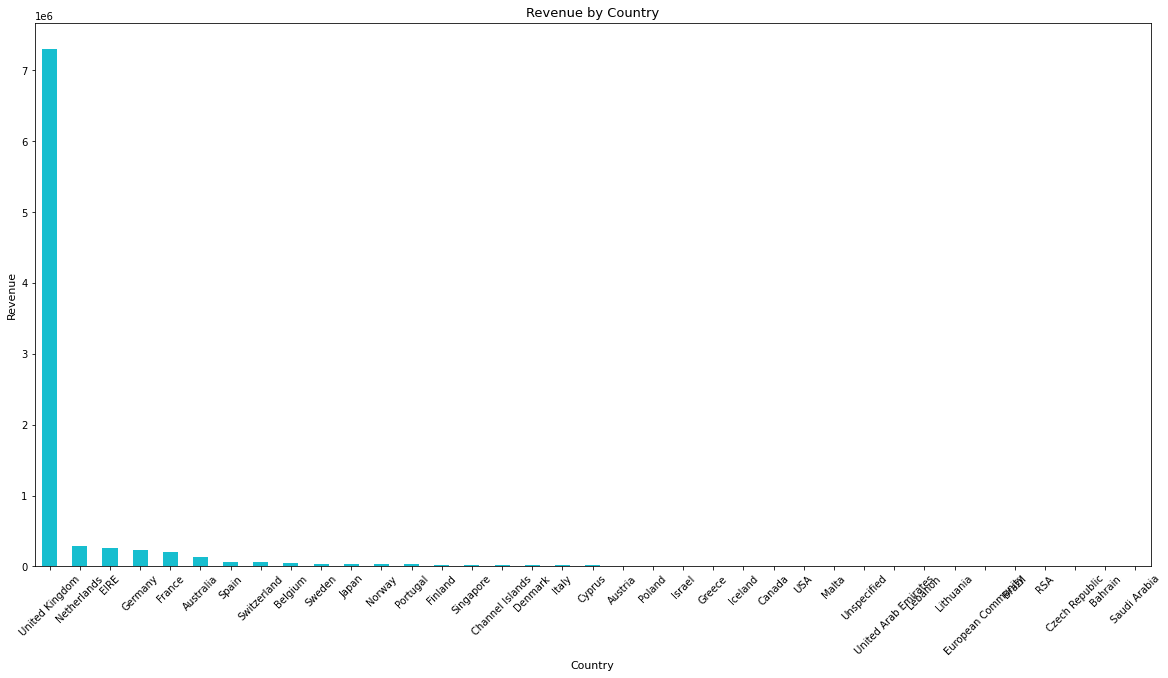

In [ ]:
plot = rev_by_countries.plot(kind='bar', color=COLORS[-1], figsize=(20, 10))
plot.set_xlabel('Country', fontsize=11)   
plot.set_ylabel('Revenue', fontsize=11)
plot.set_title('Revenue by Country', fontsize=13) 
plot.set_xticklabels(labels=rev_by_countries.index, rotation=45)    

In [ ]:
rev_by_countries / total_revenue

Country
United Kingdom         0.82
Netherlands            0.03
EIRE                   0.03
Germany                0.03
France                 0.02
Australia              0.02
Spain                  0.01
Switzerland            0.01
Belgium                0.00
Sweden                 0.00
Japan                  0.00
Norway                 0.00
Portugal               0.00
Finland                0.00
Singapore              0.00
Channel Islands        0.00
Denmark                0.00
Italy                  0.00
Cyprus                 0.00
Austria                0.00
Poland                 0.00
Israel                 0.00
Greece                 0.00
Iceland                0.00
Canada                 0.00
USA                    0.00
Malta                  0.00
Unspecified            0.00
United Arab Emirates   0.00
Lebanon                0.00
Lithuania              0.00
European Community     0.00
Brazil                 0.00
RSA                    0.00
Czech Republic         0.00
Bahrain     

#### 그래프 유틸 함수


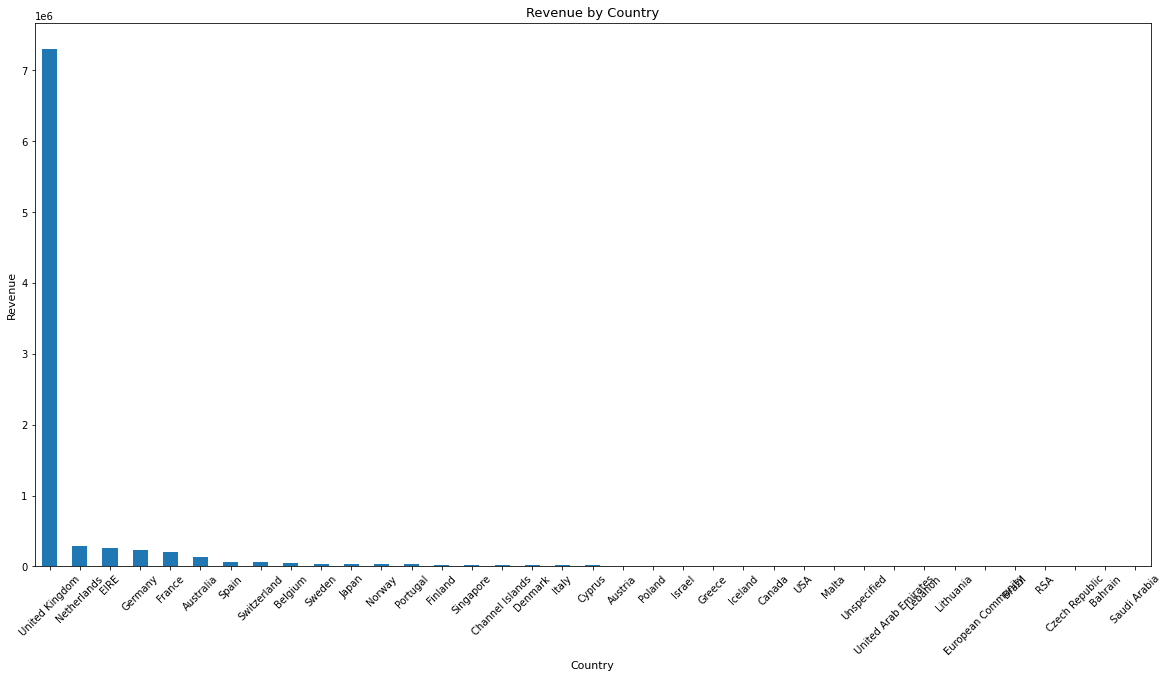

In [ ]:
def plot_bar(df, xlabel, ylabel, title, color=COLORS[0], figsize=(20, 10), rotation=45):
    plot = df.plot(kind='bar', color=color, figsize=figsize)
    plot.set_xlabel(xlabel, fontsize=11)
    plot.set_ylabel(ylabel, fontsize=11)
    plot.set_title(title, fontsize=13)
    plot.set_xticklabels(labels=df.index, rotation=rotation)
                   
plot_bar(rev_by_countries, 'Country', 'Revenue', 'Revenue by Country')  

#### 월별 매출

In [ ]:
retail['InvoiceDate'].sort_values(ascending=False)             

397883   2011-12-09 12:50:00
397875   2011-12-09 12:50:00
397882   2011-12-09 12:50:00
397870   2011-12-09 12:50:00
397871   2011-12-09 12:50:00
                 ...        
4        2010-12-01 08:26:00
3        2010-12-01 08:26:00
2        2010-12-01 08:26:00
1        2010-12-01 08:26:00
0        2010-12-01 08:26:00
Name: InvoiceDate, Length: 397884, dtype: datetime64[ns]

In [ ]:
def extract_month(date):   
    month = str(date.month)   
    if date.month < 10:   
        month = '0' + month
    return str(date.year) + month 

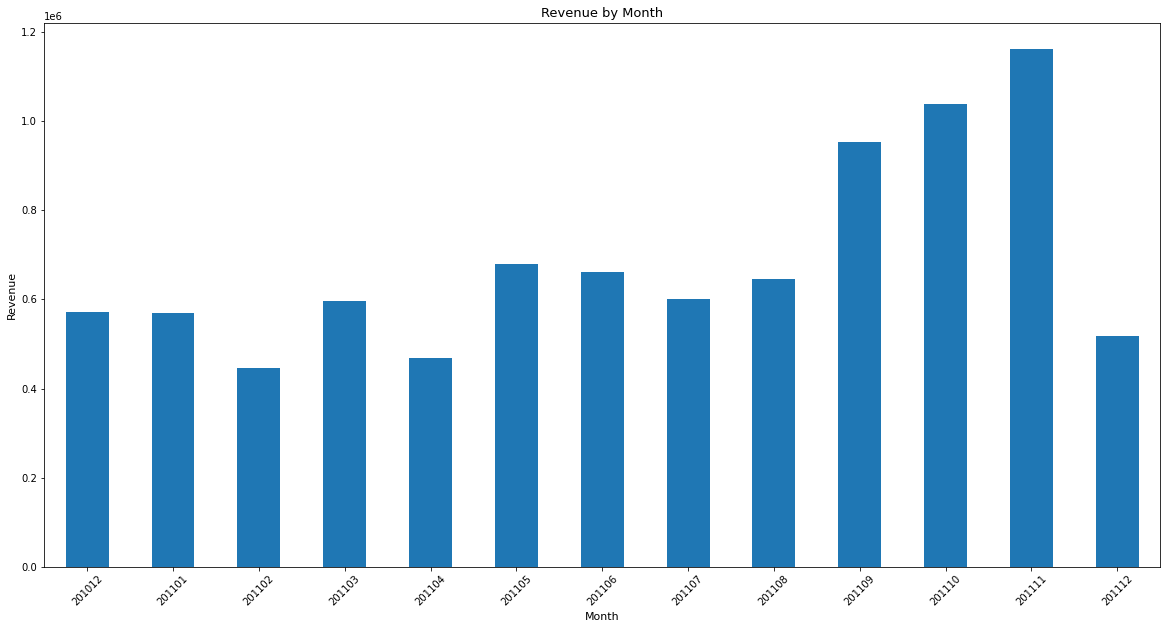

In [ ]:
rev_by_month = retail.set_index('InvoiceDate').groupby(extract_month).sum()['CheckoutPrice']      
rev_by_month             
      
plot_bar(rev_by_month, 'Month', 'Revenue', 'Revenue by Month')

#### 요일별 매출

In [ ]:
rev_by_dow = retail.set_index('InvoiceDate').groupby(lambda date:date.dayofweek).sum()['CheckoutPrice']  #월:0~일:6을 반환
rev_by_dow          

0   1367146.41
1   1700634.63
2   1588336.17
3   1976859.07
4   1485917.40
6    792514.22
Name: CheckoutPrice, dtype: float64

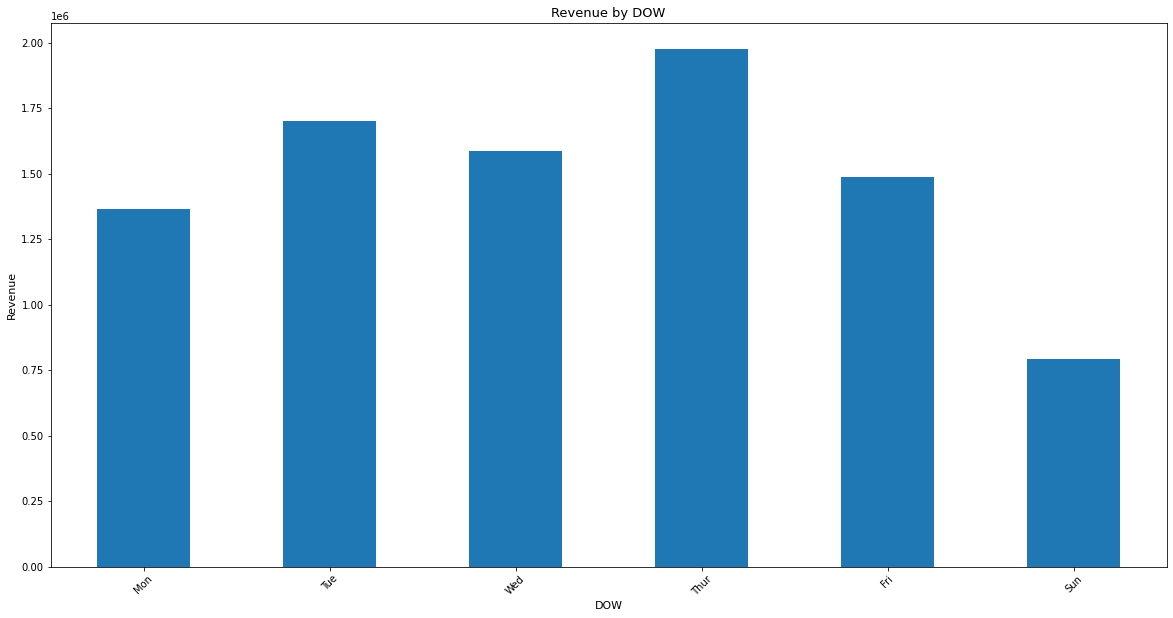

In [ ]:
DAY_OF_WEEK = np.array(['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
rev_by_dow.index = DAY_OF_WEEK[rev_by_dow.index]     #인덱스 변경           
plot_bar(rev_by_dow, 'DOW', 'Revenue', 'Revenue by DOW')             

#### 시간별 매출

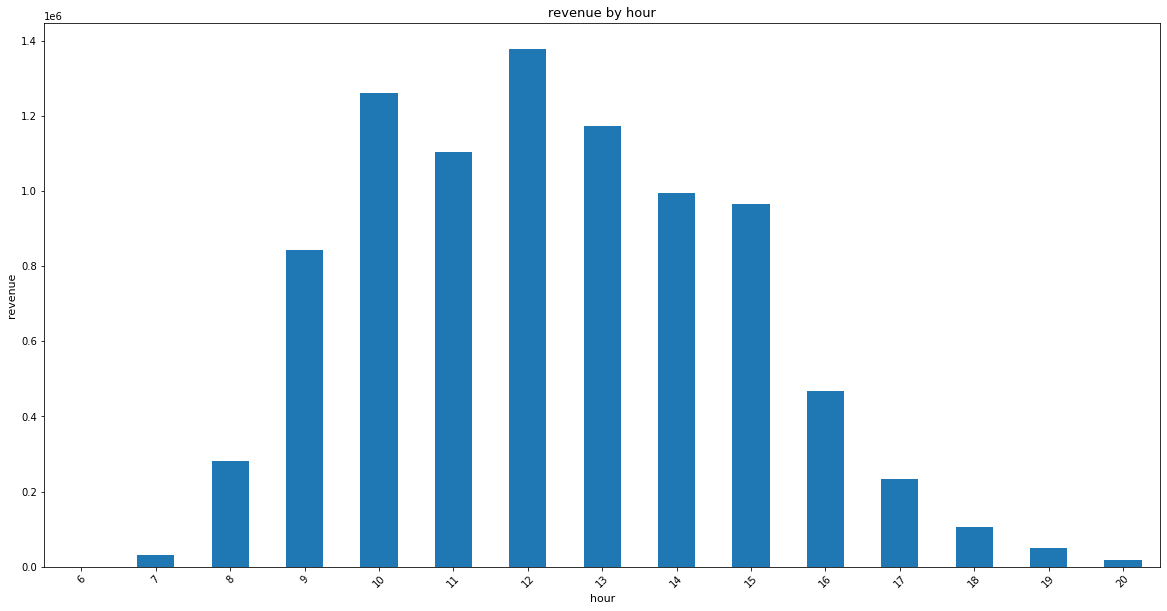

In [ ]:
rev_by_hour = retail.set_index('InvoiceDate').groupby(lambda date:date.hour).sum()['CheckoutPrice']
plot_bar(rev_by_hour, 'hour', 'revenue', 'revenue by hour')    

#### 제품별 metrics
 - Top 10 판매 제품
 - Top 10 매출 제품

In [ ]:
top_selling = retail.groupby('StockCode').sum()['Quantity'].sort_values(ascending=False)[:3]
top_selling   

StockCode
23843    80995
23166    77916
84077    54415
Name: Quantity, dtype: int32

In [ ]:
top_revenue = retail.groupby('StockCode').sum()['CheckoutPrice'].sort_values(ascending=False)[:3]    
top_revenue    

StockCode
23843    168469.60
22423    142592.95
85123A   100603.50
Name: CheckoutPrice, dtype: float64

In [ ]:
retail[retail.StockCode=='23843'].Description       

397411    PAPER CRAFT , LITTLE BIRDIE
Name: Description, dtype: object

#### top 3 아이템의 월별 판매량 추이

In [ ]:
monthly_top3 = retail.set_index('InvoiceDate').groupby(['StockCode', extract_month]).sum()[['Quantity', 'CheckoutPrice']].loc[top_selling.index]  

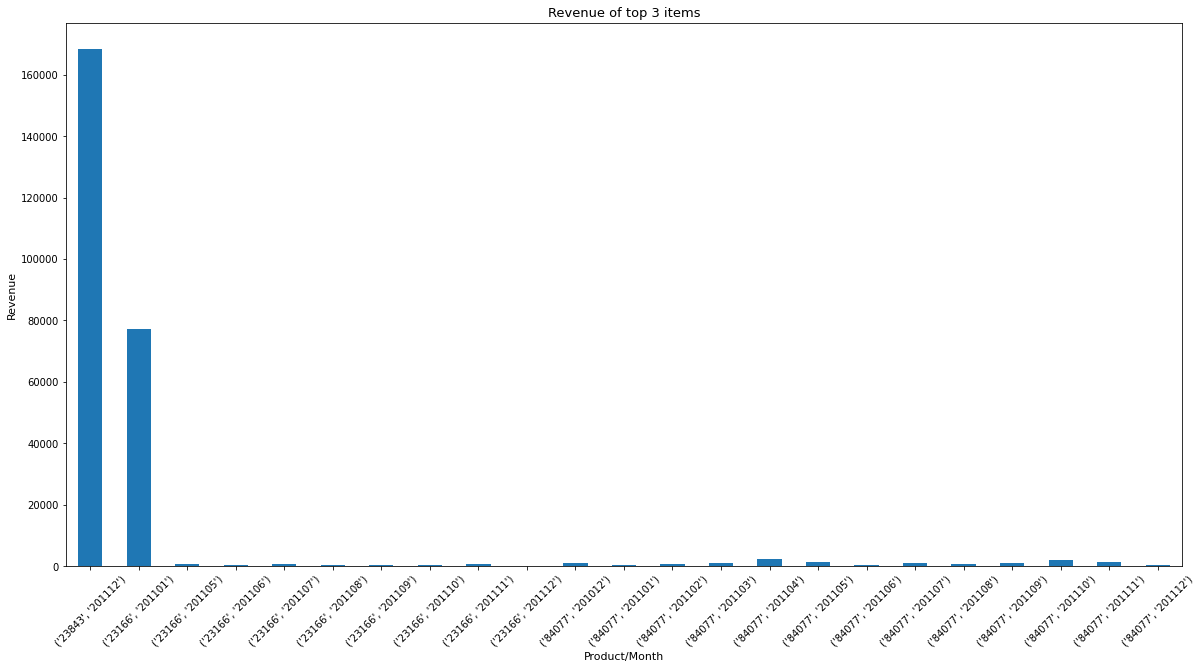

In [ ]:
plot_bar(monthly_top3['CheckoutPrice'], 'Product/Month', 'Revenue', 'Revenue of top 3 items')

#### 매출 데이터로부터 insight 
 - 전체 매출은 대략 89만 달러
 - 전체 매출의 82%가 UK에서 발생
 - 11년도의 가장 많은 주문이 발생한 달 11월
  - 11, 12월의 판매량이 압도(블랙프라이데이, 사이버먼데이, 크리스마스 휴일)
 - 일주일중 목요일까지는 성장세를 보이다가, 이후로 하락(토요일에는 주문X)
 - 7시를 시작으로 주문이 시작되어 12시까지 증가세, 15시까지 하락을, 15시 이후 부터 급락)
 - 가장 높은 판매량 아이템 아이디는 '23843' -> 작은 새 모양의 종이 공예품
 - '23843' 제품은 89만 달러 중 총 16만 달러의 매출을 기록

### <2. 학습목표-우수 고객 선별하기>
1. 소비 우수고객 찾기
2. 고객 retention 

#### 우수 고객 확인
 - 구매 횟수 기준
 - 지불 금액 기준

In [ ]:
retail.groupby('CustomerID').count()['Quantity'].sort_values(ascending=False)  

CustomerID
17841    7847
14911    5675
14096    5111
12748    4595
14606    2700
         ... 
15823       1
15802       1
15753       1
15668       1
12346       1
Name: Quantity, Length: 4338, dtype: int64

In [ ]:
retail.groupby('CustomerID').sum()['CheckoutPrice'].sort_values(ascending=False)  

CustomerID
14646   280206.02
18102   259657.30
17450   194550.79
16446   168472.50
14911   143825.06
           ...   
16878       13.30
17956       12.75
16454        6.90
14792        6.20
16738        3.75
Name: CheckoutPrice, Length: 4338, dtype: float64

#### 우수 고객 확인 
- id 17841인 고객이 대략 8천번으로 가장 구매 횟수가 높다.     
- id 14646인 고객이 대략 28만 달러로 가장 지출 금액이 높다.               

#### <3. 학습 목표-사용자 retention 재구매율 분석>
 - 월간 사용자 cohort 코호트를 바탕으로 월별 재구매율(retention) 분석하기
 - heatmap으로 한눈에 재구매율을 파악 가능
   -![코호트 분석](https://analyticsmarketing.co.kr/wp-content/uploads/2017/08/%EA%B5%AC%EA%B8%80%EC%95%A0%EB%84%90%EB%A6%AC%ED%8B%B1%EC%8A%A4_%EC%BD%94%ED%98%B8%ED%8A%B8_01.png) 출처: https://analyticsmarketing.co.kr/digital-analytics/google-analytics/1527/
   

#### 사용자 기준으로 최초 구매한 월(month) 연산하기
 - Month : 구매월(일(day)을 무시) 
 - MonthStarted: 사용자가 최초 구매한 달

In [116]:
from datetime import datetime
def get_month_as_datetime(date):   
    return datetime(date.year, date.month, 1)     #day는 1로 통일시켜 무시

retail['Month'] = retail['InvoiceDate'].apply(get_month_as_datetime)    

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01


In [117]:
month_group = retail.groupby('CustomerID')['Month']         
retail['MonthStarted'] = month_group.transform(np.min)   #가장 최초 구매한 달
         
retail.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice,Month,MonthStarted
397879,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011-12-01,2011-08-01
397880,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011-12-01,2011-08-01
397881,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-01,2011-08-01
397882,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-01,2011-08-01
397883,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France,14.85,2011-12-01,2011-08-01


#### 구매 최초 월과 현재 구매 월의 차이 계산하기
 - 각 구매가 최초 구매로 부터 얼마의 월이 지났는지 연산
 - MonthPassed : 최초 구매월로부터의 월 차이

In [118]:
retail['MonthPassed'] = (retail['Month'].dt.year - retail['MonthStarted'].dt.year) * 12 + \
    (retail['Month'].dt.month - retail['MonthStarted'].dt.month)       

In [119]:
retail.tail() #지난 월 수 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice,Month,MonthStarted,MonthPassed
397879,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011-12-01,2011-08-01,4
397880,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011-12-01,2011-08-01,4
397881,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-01,2011-08-01,4
397882,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-01,2011-08-01,4
397883,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France,14.85,2011-12-01,2011-08-01,4


#### 기준 월, MonthPassed를 기준으로 고객 카운팅
 - 기준이 되는 월과 그 월로부터 지난 기간의 고객 수를 계산

In [120]:
def get_unique_no(x):
    return len(np.unique(x)) #x는 고객 아이디   
      
cohort_group = retail.groupby(['MonthStarted', 'MonthPassed'])
cohort_df = cohort_group['CustomerID'].apply(get_unique_no).reset_index()
cohort_df.head()         

,MonthStarted,MonthPassed,CustomerID
0,2010-12-01,0,885
1,2010-12-01,1,324
2,2010-12-01,2,286
3,2010-12-01,3,340
4,2010-12-01,4,321


#### 테이블 피벗
 - pivot 함수를 이용하여 index는 MonthStarted, columns을 MonthPassed로 변경하여 테이블 변경
 - 첫번째 column을 기준으로 100분위 연산

In [121]:
cohort_df = cohort_df.pivot(index='MonthStarted', columns='MonthPassed') #pivot: 행레벨을 열레벨로 변경
cohort_df.head()      

CustomerID                       ...                            
MonthPassed          0      1      2      3   ...     9      10     11     12
MonthStarted                                  ...                            
2010-12-01       885.00 324.00 286.00 340.00  ... 350.00 331.00 445.00 235.00
2011-01-01       417.00  92.00 111.00  96.00  ... 136.00 152.00  49.00    nan
2011-02-01       380.00  71.00  71.00 108.00  ... 116.00  26.00    nan    nan
2011-03-01       452.00  68.00 114.00  90.00  ...  39.00    nan    nan    nan
2011-04-01       300.00  64.00  61.00  63.00  ...    nan    nan    nan    nan

[5 rows x 13 columns]

In [122]:
#비율로 변경
customer_cohort = cohort_df.div(cohort_df.iloc[:, 0], axis=0) * 100  #첫번째 열
customer_cohort = customer_cohort.round(decimals=2)           

customer_cohort

CustomerID                          ...                              
MonthPassed          0     1     2     3     4   ...    8     9     10    11    12
MonthStarted                                     ...                              
2010-12-01       100.00 36.61 32.32 38.42 36.27  ... 35.37 39.55 37.40 50.28 26.55
2011-01-01       100.00 22.06 26.62 23.02 32.13  ... 29.98 32.61 36.45 11.75   nan
2011-02-01       100.00 18.68 18.68 28.42 27.11  ... 24.74 30.53  6.84   nan   nan
2011-03-01       100.00 15.04 25.22 19.91 22.35  ... 27.88  8.63   nan   nan   nan
2011-04-01       100.00 21.33 20.33 21.00 19.67  ...  7.33   nan   nan   nan   nan
2011-05-01       100.00 19.01 17.25 17.25 20.77  ...   nan   nan   nan   nan   nan
2011-06-01       100.00 17.36 15.70 26.45 23.14  ...   nan   nan   nan   nan   nan
2011-07-01       100.00 18.09 20.74 22.34 27.13  ...   nan   nan   nan   nan   nan
2011-08-01       100.00 20.71 24.85 24.26 12.43  ...   nan   nan   nan   nan   nan
2011-09-01       100.00 23.41 30.10 11.37   nan  ...   nan   nan   nan   nan   nan
2011-10-01       100.00 24.02 11.45   nan   nan  ...   nan   nan   nan   nan   nan
2011-11-01       100.00 11.15   nan   nan   nan  ...   nan   nan   nan   nan   nan
2011-12-01       100.00   nan   nan   nan   nan  ...   nan   nan   nan   nan   nan

[13 rows x 13 columns]

#### heatmap 출력하기
 - seaborn의 heatmap 함수로 visualization!

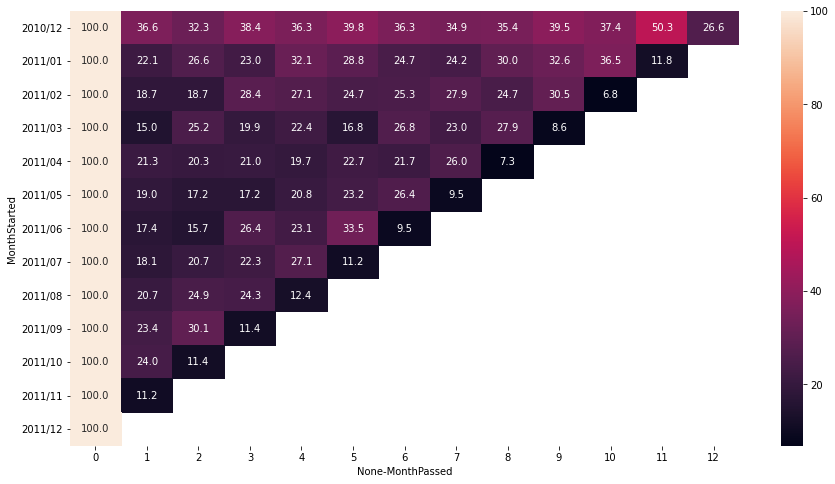

In [124]:
import matplotlib.pyplot as plt
xticks = np.arange(0, 13)
yticks = ['2010/12', '2011/01', '2011/02', '2011/03', '2011/04', '2011/05', '2011/06', '2011/07', '2011/08', '2011/09', '2011/10', '2011/11', '2011/12']

plt.figure(figsize = (15, 8))   
sns.heatmap(customer_cohort,      
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f')


### <4. 학습목표-고객에 따른 push 알림 시간대 설정>
1. 푸쉬 노티피케이션 타임 의사 결정 하기

#### 쿠폰 발송을 할때, push를 언제 보내는게 좋을까?
 - 고객에게 쿠폰 발송을 한다고 기획하고, 회의를 한다고 가정해보겠습니다. 
  - A: 쿠폰을 언제보내는게 좋을까요?
  - B: 아침에 출퇴근 시간에 보내는게 좋을까요?
  - C: 점심 먹고 졸린데 그때 보내보죠?
  - D: 흠 자기전에 스마트폰 많이 하던데 그때는 어떨까요?
  - A: 그러면 평균 시간을 내볼까요?
  - K: 아 **데이터**를 확인해보는게 맞지 않을까요? 언제 고객이 주로 주문을 하는지? 


 - 위에서 처럼 실제로 회의를 하다보면 의사결정이 본인/주변의 경험에 의해서 이뤄지는 것을 많이 볼 수 있습니다. 
 - 주문이 이뤄지는 시간을 고려하지 않고 막무가내로 보낸다면 아무 의미가 없고, 추후 같은 이벤트 발생시에도 판단 근거가 없게 됨
 - 현상태에서는 가장 많이 주문이 일어나는 시점에서 하는 것이 가장 직관적인 판단
   - 1. 데이터로 파악
   - 2. 가설 제시
   - 3. 가설 검증
   - 4. 1-3 반복
 - 시간(hour, minute)과 주로 관련되기 때문에 역시 InvoiceDate가 중요한 feature
   

In [ ]:
def plot_bar(df, xlabel, ylabel, title, figsize=(20, 10), color=COLORS[-1], rotation=45):
    plot = df.plot(kind='bar', color=color, figsize=figsize)
    plot.set_xlabel(xlabel, fontsize=10) 
    plot.set_ylabel(ylabel, fontsize=10)      
    plot.set_title(title, fontsize=12)  
    plot.set_xticklabels(labels=df.index, rotation=rotation)

In [125]:
order_by_hour = retail.set_index('InvoiceDate').groupby(lambda date: date.hour).count()['CustomerID'] #한 시간 단위로 분석
order_by_hour   

6         1
7       379
8      8690
9     21944
10    37997
11    49084
12    72065
13    64026
14    54118
15    45369
16    24089
17    13071
18     2928
19     3321
20      802
Name: CustomerID, dtype: int64

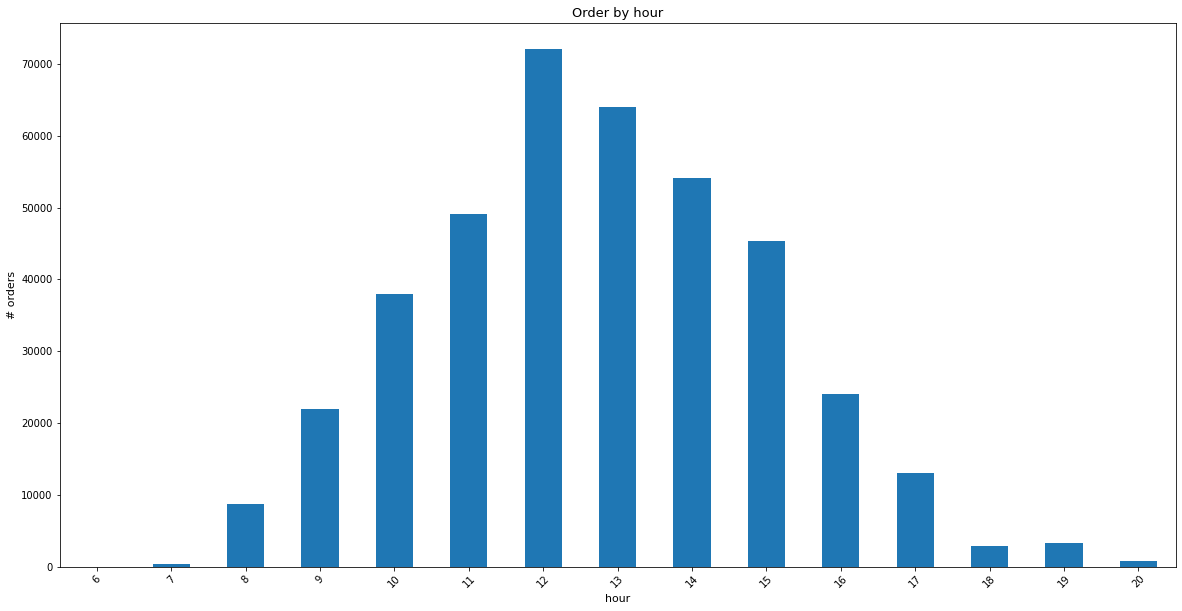

In [126]:
plot_bar(order_by_hour, 'hour', '# orders', 'Order by hour')

In [127]:
def half_an_hour(date):   #30분 단위로 분석
    minute = ':00'      
    if date.minute > 30:   
        minute = ':30'   
    hour = str(date.hour)         
    if date.hour < 10:  
        hour = '0' + hour   
          
    return hour + minute

In [128]:
order_by_hour_half = retail.set_index('InvoiceDate').groupby(half_an_hour).count()['CustomerID']
order_by_hour_half

06:00        1
07:30      379
08:00     3145
08:30     5545
09:00     9364
09:30    12580
10:00    16950
10:30    21047
11:00    18925
11:30    30159
12:00    37174
12:30    34891
13:00    31131
13:30    32895
14:00    26958
14:30    27160
15:00    24227
15:30    21142
16:00    14316
16:30     9773
17:00     8889
17:30     4182
18:00     1715
18:30     1213
19:00     1534
19:30     1787
20:00      802
Name: CustomerID, dtype: int64

In [129]:
order_by_hour_half / order_by_hour_half.sum() #비율 

06:00   0.00
07:30   0.00
08:00   0.01
08:30   0.01
09:00   0.02
09:30   0.03
10:00   0.04
10:30   0.05
11:00   0.05
11:30   0.08
12:00   0.09
12:30   0.09
13:00   0.08
13:30   0.08
14:00   0.07
14:30   0.07
15:00   0.06
15:30   0.05
16:00   0.04
16:30   0.02
17:00   0.02
17:30   0.01
18:00   0.00
18:30   0.00
19:00   0.00
19:30   0.00
20:00   0.00
Name: CustomerID, dtype: float64

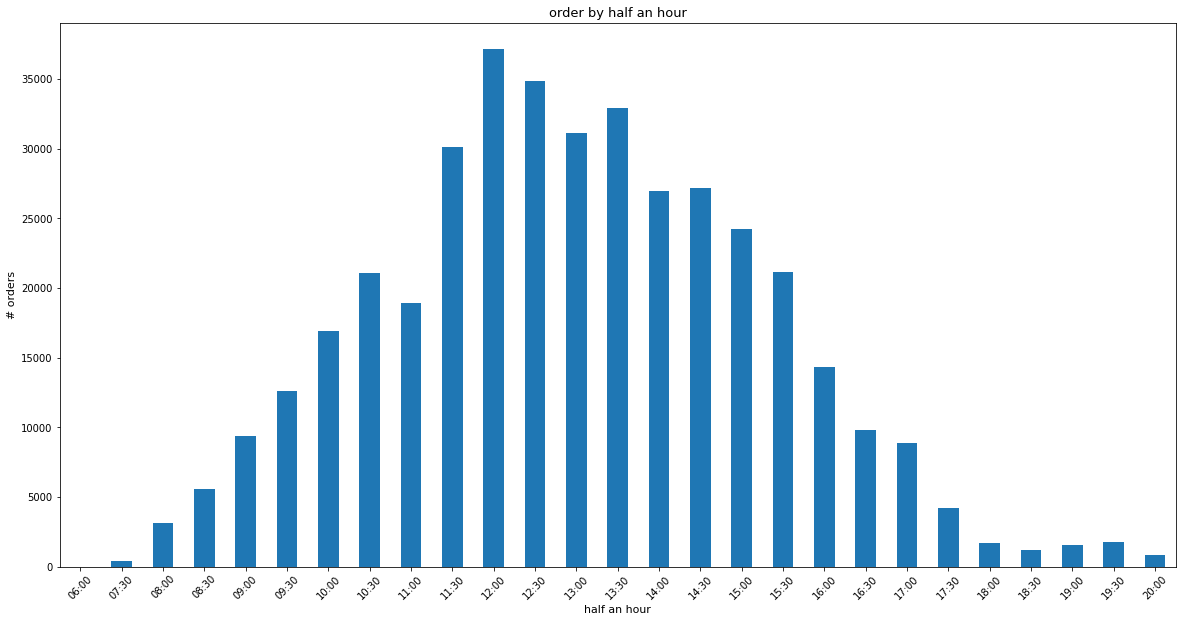

In [130]:
plot_bar(order_by_hour_half, 'half an hour', '# orders', 'order by half an hour')

#### 문제점
- 12시와 1시 사이의 구매 비율은 전체 26%를 차지하므로 나머지 74%의 고객을 고려하지 않은 판단  

#### 개인화된 push notification
 - 아마존을 필두로, 개인화(personalization)하여 맞춤으로 사용자마다 최적의 솔루션을 찾는것이 트렌드가 됨
 - 사용자별로 소비의 패턴이 다를 수 있기 때문에, 가장 많이 구매한 시간대를 찾아서 해당 시간대에 쿠폰을 발송!

#### 사용자별 각 시간별 주문량 계산하기

In [131]:
order_count_by_hour = retail.set_index('InvoiceDate').groupby(['CustomerID', lambda date: date.hour]).count()['StockCode']   
order_count_by_hour         

CustomerID    
12346       10     1
12347       8     22
            10    24
            12    47
            13    18
                  ..
18283       15     1
            16    56
            19    87
18287       9      3
            10    67
Name: StockCode, Length: 11205, dtype: int64

In [134]:
order_count_by_hour.loc[12347]  

8     22
10    24
12    47
13    18
14    60
15    11
Name: StockCode, dtype: int64

#### 사용자별 최대 주문 시간 계산하기
 - 사용자별 가장 많은 주문량을 보인 시간을 계산

In [135]:
idx = order_count_by_hour.groupby('CustomerID').idxmax()   #최대값을 갖는 인덱스를 반환

#### 해당 시간 indexing

In [136]:
result = order_count_by_hour.loc[idx]
result       

CustomerID    
12346       10      1
12347       14     60
12348       19     17
12349       9      73
12350       16     17
                 ... 
18280       9      10
18281       10      7
18282       13      7
18283       14    201
18287       10     67
Name: StockCode, Length: 4338, dtype: int64

In [137]:
result.reset_index().groupby('level_1').groups  

{7: [73, 269, 319, 344, 375, 893, 1667, 2317], 8: [46, 58, 87, 126, 172, 179, 187, 260, 278, 279, 282, 292, 306, 347, 399, 429, 496, 503, 526, 533, 549, 552, 651, 671, 747, 755, 784, 792, 800, 803, 806, 821, 838, 877, 883, 920, 944, 947, 951, 954, 1008, 1093, 1106, 1120, 1138, 1172, 1173, 1217, 1251, 1397, 1422, 1424, 1436, 1472, 1512, 1616, 1621, 1666, 1668, 1678, 1687, 1734, 1759, 1761, 1774, 1791, 1815, 1827, 1846, 1859, 1895, 1900, 1903, 1996, 2018, 2023, 2054, 2085, 2108, 2117, 2167, 2172, 2253, 2380, 2383, 2403, 2404, 2417, 2427, 2462, 2464, 2643, 2749, 2776, 2781, 2896, 2936, 2949, 3021, 3130, ...], 9: [3, 9, 26, 30, 33, 35, 37, 48, 60, 66, 75, 84, 86, 90, 100, 106, 107, 121, 127, 135, 138, 142, 144, 146, 154, 159, 181, 199, 230, 240, 264, 265, 267, 277, 280, 286, 294, 298, 328, 333, 336, 342, 343, 352, 362, 366, 385, 402, 421, 459, 470, 475, 478, 482, 483, 509, 517, 519, 574, 603, 615, 630, 636, 642, 644, 691, 701, 706, 707, 746, 749, 752, 764, 770, 781, 783, 818, 825, 829, 844